Similar studies, regarding dogs 
https://www.mdpi.com/1999-5903/14/4/97

In [1]:
import cv2
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage
import pandas as pd

In [3]:
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import math

import tensorflow as tf

In [6]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [13]:
%matplotlib inline

In [7]:
name2id = {
    'l_eye': 0,
    'r_eye': 1,
    'l_ear': 2,
    'r_ear': 3,
    'nose': 4,
    'tail': 5,
    'l_f_elbow': 6,
    'r_f_elbow': 7,
    'l_b_elbow': 8,
    'r_b_elbow': 9,
    'l_f_knee': 10,
    'r_f_knee': 11,
    'l_b_knee': 12,
    'r_b_knee': 13,
    'l_f_paw': 14,
    'r_f_paw': 15,
    'l_b_paw': 16,
    'r_b_paw': 17,
    'withers': 18
}

In [8]:
import pandas as pd
KEYPOINT_DEF = (
    "https://github.com/benjiebob/StanfordExtra/raw/master/keypoint_definitions.csv"
)
keypoint_def = pd.read_csv(KEYPOINT_DEF)
keypoint_def.head()

,Index,Name,Hex colour,Stanford,Animal-pose,(name in animal pose)
0,0,Left front leg: paw,d82400,y,y,L_F_Paw
1,1,Left front leg: middle joint,d82400,y,y,L_F_Knee
2,2,Left front leg: top,d82400,y,y,L_F_Elbow
3,3,Left rear leg: paw,fcfc00,y,y,L_B_Paw
4,4,Left rear leg: middle joint,fcfc00,y,y,L_B_Knee


In [9]:
import sys
sys.path.append('tensorflow-models/models/research')
sys.path.append('tensorflow-models/models')
from object_detection.builders import model_builder

from object_detection.utils import config_util
from object_detection.builders import optimizer_builder

from object_detection import model_lib

In [369]:
outdoor_model_path = 'tensorflow advanced vision/Haro-retinanet-detection/exported_model_frozen_extractor_19kps'


config_path = 'pipeline.config'
configs = config_util.get_configs_from_pipeline_file(os.path.join(outdoor_model_path, config_path))

detection_model = model_builder.build(
      model_config=configs['model'], is_training=False)

checkpoint_path = os.path.join(outdoor_model_path, 'checkpoint/ckpt-0')
restore_from_objects_dict = detection_model.restore_from_objects(fine_tune_checkpoint_type='full')
ckpt = tf.train.Checkpoint(**restore_from_objects_dict)
ckpt.restore(checkpoint_path).assert_existing_objects_matched()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 512, 512, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Weights restored!


In [375]:
img_name = 'mmpose_data/images/haro_test/IMG_5786'

_img = cv2.imread(img_name + '.jpg')
img = cv2.resize(_img,(512,512))
img_name_512 = '%s_512x512'%img_name + '.jpg'
cv2.imwrite(img_name_512, img)
img_data = tf.io.gfile.GFile(img_name_512, 'rb').read()
img = Image.open(BytesIO(img_data)).convert('RGB')

img_tensor = tf.convert_to_tensor(img, dtype = tf.uint8)

shapes = tf.constant(1 * [[512, 512, 3]], dtype=tf.int32)
preprocessed_images = tf.concat(
        detection_model.preprocess(tf.cast(img_tensor, tf.float32)[tf.newaxis, :])[0], axis=0)
predictions = detection_model.predict(preprocessed_images, shapes)
detections = detection_model.postprocess(predictions, shapes)

In [187]:
detections['detection_keypoint_scores'][0,0,name2id['l_f_elbow']]

<tf.Tensor: shape=(), dtype=float32, numpy=0.9956157>

In [218]:
detection_keypoint_scores = detections['detection_keypoint_scores'][0,0,:-1]
detection_keypoint_scores = tf.concat([tf.zeros((1)), detection_keypoint_scores],0)
np.array(detection_keypoint_scores)

array([0.        , 0.95538205, 0.9408447 , 0.62623966, 0.97498363,
       0.24365984, 0.35005188, 0.9956157 , 0.3787277 , 0.2355524 ,
       0.8631481 , 0.93717   , 0.64730465, 0.53527236, 0.66348666,
       0.80646914, 0.1047404 , 0.53476846, 0.28511488], dtype=float32)

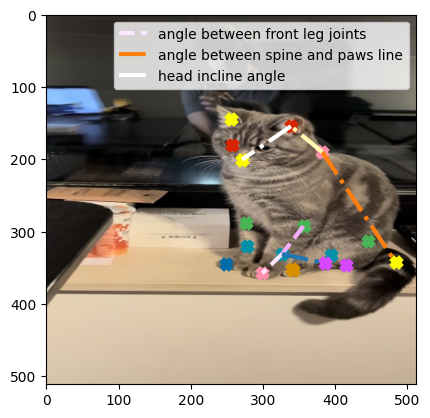

In [241]:
detected_keypoints = detections['detection_keypoints'][0,0,:]
detection_keypoint_scores = detections['detection_keypoint_scores'][0,0,:-1]
detected_keypoints = tf.concat([tf.zeros(( 1,2)), detected_keypoints[:-1,]],0)
detection_keypoint_scores = tf.concat([tf.zeros((1)), detection_keypoint_scores],0)
detection_keypoint_scores_for_pred = tf.map_fn(fn=lambda x: 1 if x>0.1 else 0, elems=detection_keypoint_scores)
detected_keypoints_for_pred = tf.concat([detected_keypoints,tf.expand_dims(detection_keypoint_scores_for_pred, 1)], 1)
detected_keypoints = tf.concat([detected_keypoints,tf.expand_dims(detection_keypoint_scores, 1)], 1)

# detected_keypoints = [detections['detection_boxes'][0,0,:2],detections['detection_boxes'][0,0,2:]]
colours = keypoint_def["Hex colour"].values.tolist()
colours = ["#" + colour for colour in colours]
plt.imshow(img)
for idx, kp in enumerate(detected_keypoints):
    # if idx == 4:
    # if idx in (name2id['r_f_knee'],name2id['r_f_elbow'],name2id['r_f_paw']):
        if kp[2] > 0.0:
            x = float(kp[0]) * 512
            y = float(kp[1]) * 512
            plt.scatter(
                [y], [x], c=colours[idx], marker="x", s=50, linewidths=5
            )

vect0 = (detected_keypoints[name2id['l_f_elbow'],:2], detected_keypoints[name2id['l_f_knee'],:2])
vect1 = (detected_keypoints[name2id['l_f_knee'],:2], detected_keypoints[name2id['l_f_paw'],:2])
plt.plot([tf.multiply(vect0[0], 512.0)[1],tf.multiply(vect0[1], 512.0)[1]], 
            [tf.multiply(vect0[0], 512.0)[0],tf.multiply(vect0[1], 512.0)[0]], '--', color ="#f6acff", linewidth=3)
plt.plot([tf.multiply(vect1[0], 512.0)[1],tf.multiply(vect1[1], 512.0)[1]], 
            [tf.multiply(vect1[0], 512.0)[0],tf.multiply(vect1[1], 512.0)[0]], '--', label = "angle between front leg joints", color = "#fce6ff", linewidth=3)


vect2 = (detected_keypoints[name2id['l_f_knee'],:2], detected_keypoints[name2id['l_b_knee'],:2])
vect3 = (detected_keypoints[name2id['withers'],:2], detected_keypoints[name2id['tail'],:2])
plt.plot([tf.multiply(vect2[0], 512.0)[1],tf.multiply(vect2[1], 512.0)[1]], 
            [tf.multiply(vect2[0], 512.0)[0],tf.multiply(vect2[1], 512.0)[0]], '-.', linewidth=3)
plt.plot([tf.multiply(vect3[0], 512.0)[1],tf.multiply(vect3[1], 512.0)[1]], 
            [tf.multiply(vect3[0], 512.0)[0],tf.multiply(vect3[1], 512.0)[0]], '-.', label = "angle between spine and paws line", linewidth=3)

vect4 = (detected_keypoints[name2id['l_ear'],:2], detected_keypoints[name2id['nose'],:2])
vect5 = (detected_keypoints[name2id['withers'],:2], detected_keypoints[name2id['l_ear'],:2])
plt.plot([tf.multiply(vect4[0], 512.0)[1],tf.multiply(vect4[1], 512.0)[1]], 
            [tf.multiply(vect4[0], 512.0)[0],tf.multiply(vect4[1], 512.0)[0]], '-.', label = "head incline angle", color="#FFFFFF", linewidth=3)
plt.plot([tf.multiply(vect5[0], 512.0)[1],tf.multiply(vect5[1], 512.0)[1]], 
            [tf.multiply(vect5[0], 512.0)[0],tf.multiply(vect5[1], 512.0)[0]], '-.', color="#fffcb2", linewidth=3)


plt.legend()
plt.show()

In [248]:
np_detected_keypoints_for_pred = np.array(detected_keypoints_for_pred)[:,[1,0,2]]
np_detected_keypoints_for_pred

array([[0.        , 0.        , 0.        ],
       [0.5013249 , 0.35234737, 1.        ],
       [0.66134375, 0.30083853, 1.        ],
       [0.4998984 , 0.28080276, 1.        ],
       [0.5295881 , 0.3910075 , 1.        ],
       [0.94471747, 0.6688502 , 1.        ],
       [0.6955435 , 0.5710089 , 1.        ],
       [0.53979105, 0.56161976, 1.        ],
       [0.870516  , 0.6103825 , 1.        ],
       [0.7693492 , 0.65030414, 1.        ],
       [0.6372994 , 0.6467981 , 1.        ],
       [0.5432596 , 0.62617254, 1.        ],
       [0.7542471 , 0.67145663, 1.        ],
       [0.8106999 , 0.6769071 , 1.        ],
       [0.58395195, 0.69862527, 1.        ],
       [0.48614448, 0.67273766, 1.        ],
       [0.66639864, 0.6890989 , 1.        ],
       [0.66548824, 0.68759465, 1.        ],
       [0.7463818 , 0.3706799 , 1.        ]], dtype=float32)

In [267]:
pose_classes = {
    'lying':0,
    'sitting':1,
    'sleeping':0,
    'standing':2,
    'moving':2,
    'jumping':3,
    'eating':4
}

In [258]:
def get_angle(line1, line2):
    # Get directional vectors
    d1 = (line1[1][0] - line1[0][0], line1[1][1] - line1[0][1])
    d2 = (line2[1][0] - line2[0][0], line2[1][1] - line2[0][1])
    # Compute dot product
    p = d1[0] * d2[0] + d1[1] * d2[1]
    # Compute norms
    n1 = math.sqrt(d1[0] * d1[0] + d1[1] * d1[1])
    n2 = math.sqrt(d2[0] * d2[0] + d2[1] * d2[1])
    # Compute angle
    ang = math.acos(p / (n1 * n2))
    # Convert to degrees if you want
    # ng_degree = math.degrees(ang)
    return ang

def process_input(keypoints):
    d = {'back_between_legs_angle':0,'front_between_legs_angle':0,'head_angle':0,'paws_spine_angle':0,
                        'lower_front_leg_spine_angle':0,'lower_back_leg_spine_angle':0,
                        'back_lowerlegs_x':0,'back_lowerlegs_y':0,'back_upperlegs_x':0,'back_upperlegs_y':0,
                        'front_lowerlegs_x':0,'front_lowerlegs_y':0,'front_upperlegs_x':0,'front_upperlegs_y':0
                        }

    if (keypoints[name2id['tail'],2] != 0 and keypoints[name2id['withers'],2] != 0):
        center_xy = ((keypoints[name2id['withers'],0] + keypoints[name2id['tail'],0])/2,
                    (keypoints[name2id['withers'],1] + keypoints[name2id['tail'],1])/2)
        spine_len = np.sqrt((np.square(keypoints[name2id['withers'],0] - keypoints[name2id['tail'],0]) + 
                    np.square(keypoints[name2id['withers'],1] + keypoints[name2id['tail'],1])))

    x_index = 0
    y_index = 1

    if (keypoints[name2id['r_b_elbow'],2] != 0 and keypoints[name2id['r_b_knee'],2] != 0 and keypoints[name2id['r_b_paw'],2] != 0):
        vect0 = ((keypoints[name2id['r_b_elbow'],0],keypoints[name2id['r_b_elbow'],1]), 
                (keypoints[name2id['r_b_knee'],0],keypoints[name2id['r_b_knee'],1]))
        vect1 = ((keypoints[name2id['r_b_knee'],0],keypoints[name2id['r_b_knee'],1]), 
                (keypoints[name2id['r_b_paw'],0],keypoints[name2id['r_b_paw'],1]))
        d['back_between_legs_angle'] = get_angle(vect0, vect1)
    elif (keypoints[name2id['l_b_elbow'],2] != 0 and keypoints[name2id['l_b_knee'],2] != 0 and keypoints[name2id['l_b_paw'],2] != 0):
        vect0 = ((keypoints[name2id['l_b_elbow'],0],keypoints[name2id['l_b_elbow'],1]), 
                (keypoints[name2id['l_b_knee'],0],keypoints[name2id['l_b_knee'],1]))
        vect1 = ((keypoints[name2id['l_b_knee'],0],keypoints[name2id['l_b_knee'],1]), 
                (keypoints[name2id['l_b_paw'],0],keypoints[name2id['l_b_paw'],1]))
        d['back_between_legs_angle'] = get_angle(vect0, vect1)

    if (keypoints[name2id['r_f_elbow'],2] != 0 and keypoints[name2id['r_f_knee'],2] != 0 and keypoints[name2id['r_f_paw'],2] != 0):
        vect0 = ((keypoints[name2id['r_f_elbow'],0],keypoints[name2id['r_f_elbow'],1]), 
                (keypoints[name2id['r_f_knee'],0],keypoints[name2id['r_f_knee'],1]))
        vect1 = ((keypoints[name2id['r_f_knee'],0],keypoints[name2id['r_f_knee'],1]), 
                (keypoints[name2id['r_f_paw'],0],keypoints[name2id['r_f_paw'],1]))
        d['front_between_legs_angle'] = get_angle(vect0, vect1)
    elif (keypoints[name2id['l_f_elbow'],2] != 0 and keypoints[name2id['l_f_knee'],2] != 0 and keypoints[name2id['l_f_paw'],2] != 0):
        vect0 = ((keypoints[name2id['l_f_elbow'],0],keypoints[name2id['l_f_elbow'],1]), 
                (keypoints[name2id['l_f_knee'],0],keypoints[name2id['l_f_knee'],1]))
        vect1 = ((keypoints[name2id['l_f_knee'],0],keypoints[name2id['l_f_knee'],1]), 
                (keypoints[name2id['l_f_paw'],0],keypoints[name2id['l_f_paw'],1]))
        d['front_between_legs_angle'] = get_angle(vect0, vect1)

    if (keypoints[name2id['nose'],2] != 0 and keypoints[name2id['withers'],2] != 0):
        if keypoints[name2id['l_ear'],2] != 0:
            vect0 = (keypoints[name2id['withers']], keypoints[name2id['l_ear']])
            vect1 = (keypoints[name2id['l_ear']], keypoints[name2id['nose']])
            d['head_angle'] = get_angle(vect0, vect1)
        elif keypoints[name2id['r_ear'],2] != 0:
            vect0 = (keypoints[name2id['withers']], keypoints[name2id['r_ear']])
            vect1 = (keypoints[name2id['r_ear']], keypoints[name2id['nose']])
            d['head_angle'] = get_angle(vect0, vect1)

    if (keypoints[name2id['tail'],2] != 0 and keypoints[name2id['withers'],2] != 0):
        if (keypoints[name2id['r_f_paw'],2] != 0 and keypoints[name2id['r_b_paw'],2] != 0):
            vect0 = (keypoints[name2id['r_f_paw']], keypoints[name2id['r_b_paw']])
            vect1 = (keypoints[name2id['withers']], keypoints[name2id['tail']])
            d['paws_spine_angle'] = get_angle(vect0, vect1)
        elif (keypoints[name2id['l_f_paw'],2] != 0 and keypoints[name2id['l_b_paw'],2] != 0):
            vect0 = (keypoints[name2id['l_f_paw']], keypoints[name2id['l_b_paw']])
            vect1 = (keypoints[name2id['withers']], keypoints[name2id['tail']])
            d['paws_spine_angle'] = get_angle(vect0, vect1)
        elif (keypoints[name2id['l_f_knee'],2] != 0 and keypoints[name2id['l_b_knee'],2] != 0):
            vect0 = (keypoints[name2id['l_f_knee']], keypoints[name2id['l_b_knee']])
            vect1 = (keypoints[name2id['withers']], keypoints[name2id['tail']])
            d['paws_spine_angle'] = get_angle(vect0, vect1)
        elif (keypoints[name2id['r_f_knee'],2] != 0 and keypoints[name2id['r_b_knee'],2] != 0):
            vect0 = (keypoints[name2id['r_f_knee']], keypoints[name2id['r_b_knee']])
            vect1 = (keypoints[name2id['withers']], keypoints[name2id['tail']])
            d['paws_spine_angle'] = get_angle(vect0, vect1)

        if (keypoints[name2id['r_f_paw'],2] != 0 and keypoints[name2id['r_f_knee'],2] != 0):
            vect0 = (keypoints[name2id['r_f_paw']], keypoints[name2id['r_f_knee']])
            vect1 = (keypoints[name2id['withers']], keypoints[name2id['tail']])
            d['lower_front_leg_spine_angle'] = get_angle(vect0, vect1)
        elif (keypoints[name2id['l_f_paw'],2] != 0 and keypoints[name2id['l_f_knee'],2] != 0):
            vect0 = (keypoints[name2id['l_f_paw']], keypoints[name2id['l_f_knee']])
            vect1 = (keypoints[name2id['withers']], keypoints[name2id['tail']])
            d['lower_front_leg_spine_angle'] = get_angle(vect0, vect1)

        if (keypoints[name2id['r_b_paw'],2] != 0 and keypoints[name2id['r_b_knee'],2] != 0):
            vect0 = (keypoints[name2id['r_b_paw']], keypoints[name2id['r_b_knee']])
            vect1 = (keypoints[name2id['withers']], keypoints[name2id['tail']])
            d['lower_back_leg_spine_angle'] = get_angle(vect0, vect1)
        elif (keypoints[name2id['l_b_paw'],2] != 0 and keypoints[name2id['l_b_knee'],2] != 0):
            vect0 = (keypoints[name2id['l_b_paw']], keypoints[name2id['l_b_knee']])
            vect1 = (keypoints[name2id['withers']], keypoints[name2id['tail']])
            d['lower_back_leg_spine_angle'] = get_angle(vect0, vect1)

        if (keypoints[name2id['r_b_paw'],2] != 0 and keypoints[name2id['r_b_knee'],2] != 0):
            d['back_lowerlegs_x'] = np.abs(keypoints[name2id['r_b_paw'],x_index] - keypoints[name2id['r_b_knee'],x_index])/spine_len
            d['back_lowerlegs_y'] = np.abs(keypoints[name2id['r_b_paw'],y_index] - keypoints[name2id['r_b_knee'],y_index])/spine_len
        elif (keypoints[name2id['l_b_paw'],2] != 0 and keypoints[name2id['l_b_knee'],2] != 0):
            d['back_lowerlegs_x'] = np.abs(keypoints[name2id['l_b_paw'],x_index] - keypoints[name2id['l_b_knee'],x_index])/spine_len
            d['back_lowerlegs_y'] = np.abs(keypoints[name2id['l_b_paw'],y_index] - keypoints[name2id['l_b_knee'],y_index])/spine_len

        if (keypoints[name2id['r_b_elbow'],2] != 0 and keypoints[name2id['r_b_knee'],2] != 0):
            d['back_upperlegs_x'] = np.abs(keypoints[name2id['r_b_elbow'],x_index] - keypoints[name2id['r_b_knee'],x_index])/spine_len
            d['back_upperlegs_y'] = np.abs(keypoints[name2id['r_b_elbow'],y_index] - keypoints[name2id['r_b_knee'],y_index])/spine_len
        elif (keypoints[name2id['l_b_elbow'],2] != 0 and keypoints[name2id['l_b_knee'],2] != 0):
            d['back_upperlegs_x'] = np.abs(keypoints[name2id['l_b_elbow'],x_index] - keypoints[name2id['l_b_knee'],x_index])/spine_len
            d['back_upperlegs_y'] = np.abs(keypoints[name2id['l_b_elbow'],y_index] - keypoints[name2id['l_b_knee'],y_index])/spine_len

        if (keypoints[name2id['r_f_paw'],2] != 0 and keypoints[name2id['r_f_knee'],2] != 0):
            d['front_lowerlegs_x'] = np.abs(keypoints[name2id['r_f_paw'],x_index] - keypoints[name2id['r_f_knee'],x_index])/spine_len
            d['front_lowerlegs_y'] = np.abs(keypoints[name2id['r_f_paw'],y_index] - keypoints[name2id['r_f_knee'],y_index])/spine_len
        elif (keypoints[name2id['l_b_paw'],2] != 0 and keypoints[name2id['l_b_knee'],2] != 0):
            d['front_lowerlegs_x'] = np.abs(keypoints[name2id['l_f_paw'],x_index] - keypoints[name2id['l_f_knee'],x_index])/spine_len
            d['front_lowerlegs_y'] = np.abs(keypoints[name2id['l_f_paw'],y_index] - keypoints[name2id['l_f_knee'],y_index])/spine_len

        if (keypoints[name2id['r_f_elbow'],2] != 0 and keypoints[name2id['r_f_knee'],2] != 0):
            d['front_upperlegs_x'] = np.abs(keypoints[name2id['r_f_elbow'],x_index] - keypoints[name2id['r_f_knee'],x_index])/spine_len
            d['front_upperlegs_y'] = np.abs(keypoints[name2id['r_f_elbow'],y_index] - keypoints[name2id['r_f_knee'],y_index])/spine_len
        elif (keypoints[name2id['l_f_elbow'],2] != 0 and keypoints[name2id['l_f_knee'],2] != 0):
            d['front_upperlegs_x'] = np.abs(keypoints[name2id['l_f_elbow'],x_index] - keypoints[name2id['l_f_knee'],x_index])/spine_len
            d['front_upperlegs_y'] = np.abs(keypoints[name2id['l_f_elbow'],y_index] - keypoints[name2id['l_f_knee'],y_index])/spine_len
    return d

In [251]:
classifier_interpreter = tf.lite.Interpreter(model_path = 'cat_pose_classifier.tflite')
classifier_interpreter.allocate_tensors()

In [253]:
# Get input and output tensors.
input_details = classifier_interpreter.get_input_details()
output_details = classifier_interpreter.get_output_details()

In [262]:
input_details

[{'name': 'serving_default_input_2:0',
  'index': 0,
  'shape': array([ 1, 14], dtype=int32),
  'shape_signature': array([-1, 14], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [264]:
d = process_input(np_detected_keypoints_for_pred)
d_inp = {}
for k,v in d.items():
    d_inp[k] = [v]
classifier_interpreter.set_tensor(input_details[0].get('index'), pd.DataFrame(d_inp).astype('float32'))

In [270]:
pose_classes_names = ['lying','sitting','standing','jumping','eating']

In [271]:
classifier_interpreter.invoke()
output_data = classifier_interpreter.get_tensor(output_details[0]['index'])
print('result class %s'%pose_classes_names[np.argmax(output_data)])

result class sitting


Model training

In [190]:
detection_keypoint_scores

<tf.Tensor: shape=(19,), dtype=float32, numpy=
array([0.95538205, 0.9408447 , 0.62623966, 0.97498363, 0.24365984,
       0.35005188, 0.9956157 , 0.3787277 , 0.2355524 , 0.8631481 ,
       0.93717   , 0.64730465, 0.53527236, 0.66348666, 0.80646914,
       0.1047404 , 0.53476846, 0.28511488, 0.1       ], dtype=float32)>

In [42]:
if detections['detection_keypoint_scores'][0,0,name2id['withers'] - 1] > 0.1:
    if detections['detection_keypoint_scores'][0,0,name2id['tail'] - 1] > 0.1:
        print('scaling with tail')
    elif detections['detection_keypoint_scores'][0,0,name2id['l_b_elbow'] - 1] > 0.1:
        print('scaling with l_b_elbow')
    elif detections['detection_keypoint_scores'][0,0,name2id['r_b_elbow'] - 1] > 0.1:
        print('scaling with r_b_elbow')

scaling with r_b_elbow


In [53]:
detected_keypoints

<tf.Tensor: shape=(19, 2), dtype=float32, numpy=
array([[0.35234737, 0.5013249 ],
       [0.30083853, 0.66134375],
       [0.28080276, 0.4998984 ],
       [0.3910075 , 0.5295881 ],
       [0.6688502 , 0.94471747],
       [0.5710089 , 0.6955435 ],
       [0.56161976, 0.53979105],
       [0.6103825 , 0.870516  ],
       [0.65030414, 0.7693492 ],
       [0.6467981 , 0.6372994 ],
       [0.62617254, 0.5432596 ],
       [0.67145663, 0.7542471 ],
       [0.6769071 , 0.8106999 ],
       [0.69862527, 0.58395195],
       [0.67273766, 0.48614448],
       [0.6890989 , 0.66639864],
       [0.68759465, 0.66548824],
       [0.3706799 , 0.7463818 ],
       [0.54985666, 0.7187773 ]], dtype=float32)>

In [9]:
pose_csv_path = 'tensorflow advanced vision/Haro-retinanet-detection/pose_landmarks1.csv'
df = pd.read_csv(pose_csv_path)

In [11]:
df.columns

Index(['Unnamed: 0', 'back_between_legs_angle', 'front_between_legs_angle',
       'head_angle', 'paws_spine_angle', 'lower_front_leg_spine_angle',
       'lower_back_leg_spine_angle', 'back_lowerlegs_x', 'back_lowerlegs_y',
       'back_upperlegs_x', 'back_upperlegs_y', 'front_lowerlegs_x',
       'front_lowerlegs_y', 'front_upperlegs_x', 'front_upperlegs_y',
       'file_name', 'class'],
      dtype='object')

In [8]:
def load_pose_landmarks(csv_path):

  # Load the CSV file
  dataframe = pd.read_csv(csv_path)
  dataframe = dataframe[dataframe['class'].notnull()]
  df_to_process = dataframe.copy()

  # Drop the file_name columns as you don't need it during training.  
  df_to_process.drop(columns=['file_name'], inplace=True)
  df_to_process.drop(columns=['Unnamed: 0'], inplace=True)

  # Extract the list of class names
  classes = ['lying','sitting','standing','jumping','eating']
  # Extract the labels
  y = df_to_process.pop('class')

  # Convert the input features and labels into the correct format for training.
  X = df_to_process.astype('float64')
  y = tf.keras.utils.to_categorical(y)

  return X, y, classes, dataframe

In [11]:
# Load the train data
X, y, class_names, _ = load_pose_landmarks(pose_csv_path)

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
# Split training data (X, y) into (X_train, y_train) and (X_val, y_val)
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.15)

In [55]:
def landmarks_to_embedding(landmarks_and_scores):
  """Converts the input landmarks into a pose embedding."""
  # Reshape the flat input into a matrix with shape=(17, 3)
  reshaped_inputs = tf.keras.layers.Reshape((18, 3))(landmarks_and_scores)

  # Flatten the normalized landmark coordinates into a vector
  embedding = tf.keras.layers.Flatten()(reshaped_inputs)

  return embedding

In [ ]:
# Define the model
inputs = tf.keras.Input(shape=(14))

# embedding = landmarks_to_embedding(inputs)

layer = tf.keras.layers.Dense(128, activation=tf.nn.relu)(inputs)
layer = tf.keras.layers.Dropout(0.5)(layer)
layer = tf.keras.layers.Dense(64, activation=tf.nn.relu)(layer)
layer = tf.keras.layers.Dropout(0.5)(layer)
outputs = tf.keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = tf.keras.Model(inputs, outputs)
model.summary()

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Start training
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=16,
                    validation_data=(X_val, y_val))